In [4]:
# Check the albumenation librari existance in the folder
# !pip install --upgrade albumentations
# !pip install opencv-python

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import albumentations as A
import random

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
data_annotations = pd.read_csv('White_albumenation/annotations_train.csv', header=None)
data_annotations.columns = ['image_name', 'x_min', 'y_min', 'x_max', 'y_max','class_name']

In [5]:
data_annotations.head(10)

,image_name,x_min,y_min,x_max,y_max,class_name
0,train/Romania_foto_1058.jpg,3,377,691,953,price_tag
1,train/Romania_foto_1058.jpg,24,443,440,486,product_name
2,train/Romania_foto_1058.jpg,28,874,223,908,product_id
3,train/Romania_foto_1058.jpg,395,608,502,896,price_lei
4,train/Romania_foto_1058.jpg,515,726,620,886,price_bani
5,train/Romania_foto_1065.jpg,165,247,802,749,price_tag
6,train/Romania_foto_1065.jpg,192,292,613,333,product_name
7,train/Romania_foto_1065.jpg,220,682,389,720,product_id
8,train/Romania_foto_1065.jpg,447,437,647,697,price_lei
9,train/Romania_foto_1065.jpg,643,547,748,693,price_bani


In [6]:
# Functions for vusialization
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox) # This raw should be changed for coco. This is pascal_voc format
    

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [8]:
# Read test image
image = cv2.imread('White_albumenation/train/Romania_foto_671.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [10]:
data_annotations[data_annotations.image_name == 'train/Romania_foto_671.jpg'][['x_min', 'y_min', 'x_max', 'y_max']]

,x_min,y_min,x_max,y_max
630,7,334,739,730
631,25,374,482,426
632,43,646,180,666
633,491,431,567,686
634,576,524,713,693


In [11]:
data_annotations[data_annotations.image_name == 'train/Romania_foto_671.jpg'][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

array([[  7, 334, 739, 730],
       [ 25, 374, 482, 426],
       [ 43, 646, 180, 666],
       [491, 431, 567, 686],
       [576, 524, 713, 693]])

In [12]:
a = data_annotations[data_annotations.image_name == 'train/Romania_foto_671.jpg'][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

In [13]:
bboxes = a
category_ids = [0, 1, 2, 3, 4]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {0: 'price_tag', 
                       1: 'product_name',
                       2: 'product_id',
                       3: 'price_lei',
                       4: 'price_bani'}

## **Define transformers**

In [41]:
category_ids = [0, 1, 2, 3, 4]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {0: 'price_tag', 
                       1: 'product_name',
                       2: 'product_id',
                       3: 'price_lei',
                       4: 'price_bani'}

In [52]:
# Blur
transform_Blur = A.Compose(
    [A.Blur(blur_limit=(3,23), p=1.0)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [43]:
# Motion blur
transform_MotionBlur = A.Compose(
    [A.MotionBlur(always_apply=False, p=1.0, blur_limit=(3, 26))],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [44]:
# GaussNoise light
transform_GaussNoiseLight = A.Compose(
    [A.GaussNoise(always_apply=False, p=1.0, mean=40, var_limit=(10.0, 430.0))],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [53]:
# GaussNoise dark
transform_GaussNoiseDark = A.Compose(
    [A.GaussNoise(always_apply=False,p=1.0, mean=-74.34, var_limit=(10.0, 101.0))],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [46]:
# strong color change dark
transform_RandomBrightnessContrast1 = A.Compose(
    [A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.45, 0.8), contrast_limit=(-0.7, 0.33), brightness_by_max=True)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [47]:
# strong color change
transform_RandomBrightnessContrast2 = A.Compose(
    [A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.45, 0.8), contrast_limit=(-1, 0.12), brightness_by_max=True)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [48]:
# Image compresion
transform_ImageCompression = A.Compose(
    [A.ImageCompression(always_apply=False, p=1.0, quality_lower=0, quality_upper=10, compression_type=0)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [49]:
# To gray
transform_ToGray = A.Compose(
    [A.ToGray(always_apply=False, p=1.0)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [54]:
# To sepia
transform_ToSepia = A.Compose(
    [A.ToSepia(always_apply=False, p=1.0)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


In [55]:
# CLAHE
transform_CLAHE = A.Compose(
    [A.CLAHE(always_apply=False, p=1.0, clip_limit=(1, 44), tile_grid_size=(27, 26))],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)


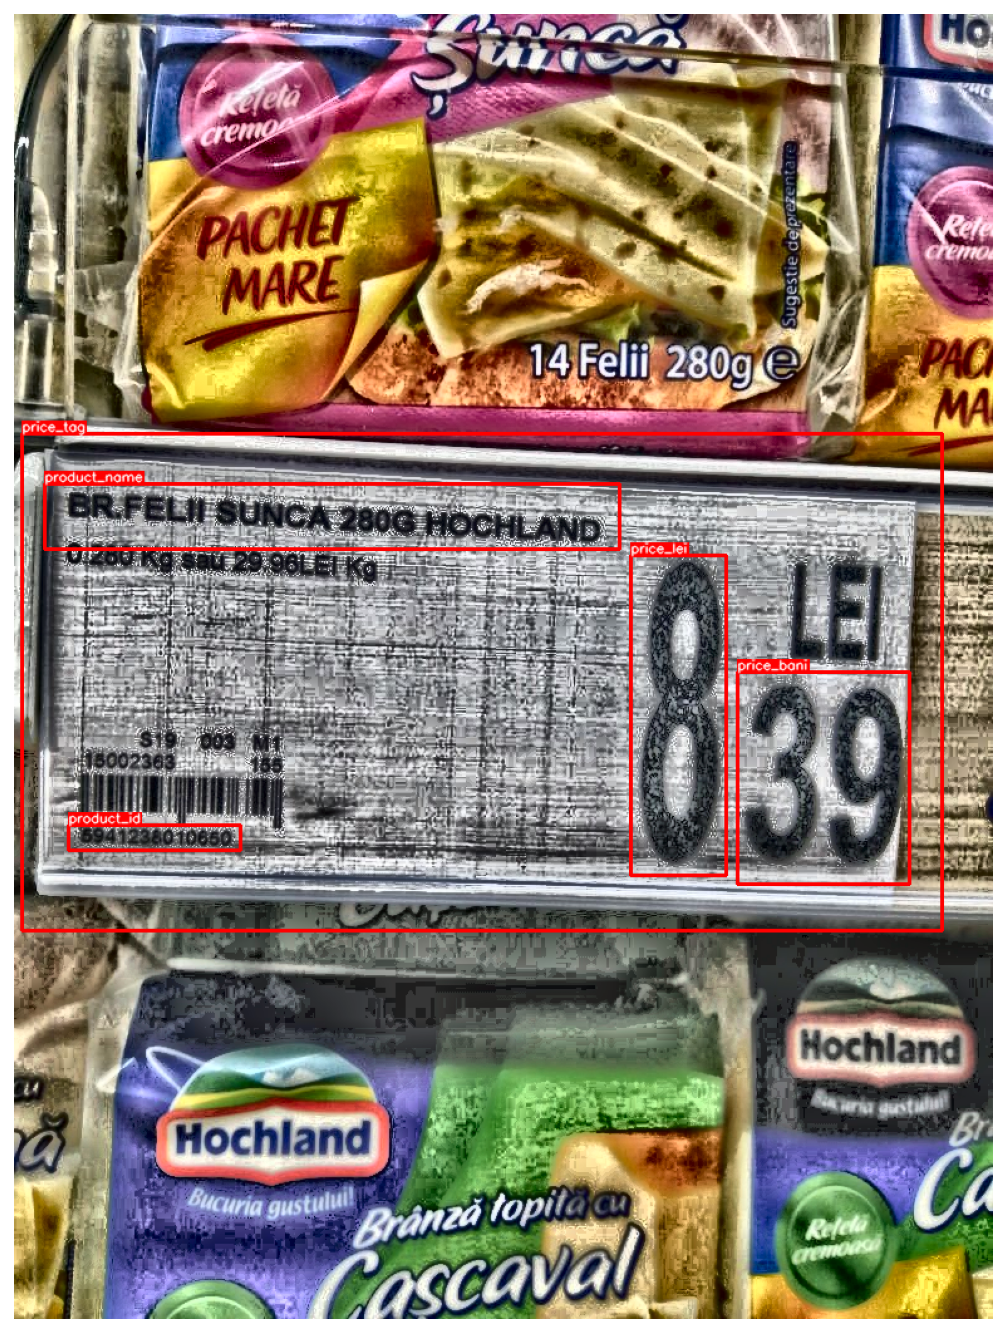

In [22]:
# Test transformers results here
random.seed(7)
transformed = transform_clahe(image=image, bboxes=bboxes, category_ids=category_ids)

visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)


## **Include only the necessary transformers**

In [56]:
# Create a list of transormers for use in the function (test with only 2 of them)
transformers_list = [transform_Blur, 
                     transform_MotionBlur, 
                     transform_GaussNoiseLight, 
                     transform_GaussNoiseDark,
                     transform_RandomBrightnessContrast1, 
                     transform_RandomBrightnessContrast2, 
                     transform_ImageCompression,
                     transform_ToGray,
                     transform_ToSepia,
                     transform_CLAHE]

## **Define a function**

In [23]:
# Create a new dataframe for aug files
data_annotations_aug = pd.DataFrame().reindex_like(data_annotations)
data_annotations_aug.dropna(inplace=True)
data_annotations_aug.head(2)

,image_name,x_min,y_min,x_max,y_max,class_name


In [26]:
DATASET_DIR = 'White_albumenation/train'

In [36]:
IMAGES_PATH = 'White_albumenation/train_augmented'

In [37]:
FOLDER_IMAGES = 'train_augmented'

In [58]:
filter = 'train/' + 'Romania_foto_1005.jpg'

In [66]:
# Test on only one file!!!!
%%time
for jpg_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".jpg")]:
    filter = 'train/' + jpg_file # Here need to change as in the annitation file
    bboxes = data_annotations[data_annotations.image_name == filter][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
    
    path_jpg_file = os.path.join(DATASET_DIR, jpg_file)
    
    image_before = cv2.imread(path_jpg_file)
    image_before = cv2.cvtColor(image_before, cv2.COLOR_BGR2RGB)
    
    # Transformers
    for t, transform in enumerate(transformers_list):
        transformed = transform(image=image_before, bboxes=bboxes, category_ids=category_ids)

        file_name = f'{jpg_file}_trans_{t}.jpg'

        cv2.imwrite(f'{IMAGES_PATH}/{file_name}', transformed['image'])

        for i, bbox in enumerate(transformed['bboxes']):
            x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
            data_annotations_aug = data_annotations_aug.append({
                                                                  'image_name': f'{FOLDER_IMAGES}/{file_name}',
                                                                  'x_min': x_min,
                                                                  'y_min': y_min,
                                                                  'x_max': x_max,
                                                                  'y_max': y_max,
                                                                  'class_name': transformed['category_ids'][i]
                                                                }, ignore_index=True)

  

## **Save new annotations CSV file**

In [68]:
data_annotations_aug.head(2)

,image_name,x_min,y_min,x_max,y_max,class_name
0,train_augmented/Romania_foto_671.jpg_trans_0.jpg,6.0,334.0,739.0,730.0,0.0
1,train_augmented/Romania_foto_671.jpg_trans_0.jpg,24.0,374.0,482.0,426.0,1.0


In [65]:
#Use your dictionary to replace classes in the dataframe
category_id_to_name = {0: 'price_tag', 
                       1: 'product_name',
                       2: 'product_id',
                       3: 'price_lei',
                       4: 'price_bani'}

In [71]:
data_annotations_aug.class_name.replace({0: 'price_tag', 
                       1: 'product_name',
                       2: 'product_id',
                       3: 'price_lei',
                       4: 'price_bani'}, inplace=True)

In [72]:
data_annotations_aug.head(2)

,image_name,x_min,y_min,x_max,y_max,class_name
0,train_augmented/Romania_foto_671.jpg_trans_0.jpg,6.0,334.0,739.0,730.0,price_tag
1,train_augmented/Romania_foto_671.jpg_trans_0.jpg,24.0,374.0,482.0,426.0,product_name


In [73]:
data_annotations_aug.to_csv('White_albumenation/annotation_train_augmented.csv', header=False, index=False)

In [62]:
# Truncate all rows
data_annotations_aug = data_annotations_aug.truncate(before=-1, after=-1)
data_annotations_aug.head()

,image_name,x_min,y_min,x_max,y_max,class_name


## **Save new classes CSV file**

In [79]:
data_classes_aug = pd.DataFrame.from_dict(category_id_to_name, orient='index', columns=['class_name']).reset_index()
data_classes_aug = data_classes_aug[['class_name','index']]
data_classes_aug

,class_name,index
0,price_tag,0
1,product_name,1
2,product_id,2
3,price_lei,3
4,price_bani,4


In [81]:
data_classes_aug.to_csv('White_albumenation/classes_train_augmented.csv', header=False, index=False)

## **Save new classes CSV for learning only on Price-tags**

In [82]:
data_classes_aug_price_tag = data_classes_aug.copy(deep=True)
data_classes_aug_price_tag.drop([1,2,3,4], axis=0, inplace=True)
data_classes_aug_price_tag

,class_name,index
0,price_tag,0


In [83]:
data_classes_aug.to_csv('White_albumenation/classes_train_aug_price_tag.csv', header=False, index=False)

## **Save new annotation CSV for learning only on Price-tags**

In [85]:
data_annotation_aug_price_tag = data_annotations_aug.copy(deep=True)

In [92]:
data_annotation_aug_price_tag.drop(data_annotation_aug_price_tag[data_annotation_aug_price_tag.class_name != 'price_tag'].index, axis=0, inplace=True)

In [93]:
data_annotation_aug_price_tag

,image_name,x_min,y_min,x_max,y_max,class_name
0,train_augmented/Romania_foto_671.jpg_trans_0.jpg,6.0,334.0,739.0,730.0,price_tag
5,train_augmented/Romania_foto_671.jpg_trans_1.jpg,6.0,334.0,739.0,730.0,price_tag
10,train_augmented/Romania_foto_671.jpg_trans_2.jpg,6.0,334.0,739.0,730.0,price_tag
15,train_augmented/Romania_foto_671.jpg_trans_3.jpg,6.0,334.0,739.0,730.0,price_tag
20,train_augmented/Romania_foto_671.jpg_trans_4.jpg,6.0,334.0,739.0,730.0,price_tag
...,...,...,...,...,...,...
7525,train_augmented/Romania_foto_765.jpg_trans_5.jpg,2.0,527.0,856.0,930.0,price_tag
7530,train_augmented/Romania_foto_765.jpg_trans_6.jpg,2.0,527.0,856.0,930.0,price_tag
7535,train_augmented/Romania_foto_765.jpg_trans_7.jpg,2.0,527.0,856.0,930.0,price_tag
7540,train_augmented/Romania_foto_765.jpg_trans_8.jpg,2.0,527.0,856.0,930.0,price_tag


In [94]:
data_annotation_aug_price_tag.to_csv('White_albumenation/annotations_train_aug_price_tag.csv', header=False, index=False)

## **Save new classes CSV for learning only on product_name, product_id, price_lei, price_bani**

In [96]:
data_classes_aug_product_price = data_classes_aug.copy(deep=True)
data_classes_aug_product_price.drop([0], axis=0, inplace=True)
data_classes_aug_product_price['index'].replace({1: 0,
                                                 2: 1,
                                                 3: 2,
                                                 4: 3}, inplace=True)
data_classes_aug_product_price

,class_name,index
1,product_name,0
2,product_id,1
3,price_lei,2
4,price_bani,3


In [97]:
data_classes_aug_product_price.to_csv('White_albumenation/classes_train_aug_product_price_tag.csv', header=False, index=False)

## **Save new annotations CSV for learning only on product_name, product_id, price_lei, price_bani**

In [101]:
data_annotation_aug_product_price = data_annotations_aug.copy(deep=True)

In [103]:
data_annotation_aug_product_price.drop(data_annotation_aug_product_price[data_annotation_aug_product_price.class_name == 'price_tag'].index, axis=0, inplace=True)

In [104]:
data_annotation_aug_product_price

,image_name,x_min,y_min,x_max,y_max,class_name
1,train_augmented/Romania_foto_671.jpg_trans_0.jpg,24.0,374.0,482.0,426.0,product_name
2,train_augmented/Romania_foto_671.jpg_trans_0.jpg,43.0,646.0,180.0,666.0,product_id
3,train_augmented/Romania_foto_671.jpg_trans_0.jpg,491.0,431.0,567.0,686.0,price_lei
4,train_augmented/Romania_foto_671.jpg_trans_0.jpg,576.0,524.0,713.0,693.0,price_bani
6,train_augmented/Romania_foto_671.jpg_trans_1.jpg,24.0,374.0,482.0,426.0,product_name
...,...,...,...,...,...,...
7544,train_augmented/Romania_foto_765.jpg_trans_8.jpg,652.0,731.0,820.0,880.0,price_bani
7546,train_augmented/Romania_foto_765.jpg_trans_9.jpg,17.0,558.0,467.0,615.0,product_name
7547,train_augmented/Romania_foto_765.jpg_trans_9.jpg,82.0,818.0,232.0,841.0,product_id
7548,train_augmented/Romania_foto_765.jpg_trans_9.jpg,535.0,621.0,657.0,878.0,price_lei


In [105]:
data_annotation_aug_product_price.to_csv('White_albumenation/annotations_train_aug_product_price_tag.csv', header=False, index=False)